<hr/> <h1 style="text-align: center;"><span style="color: #666699;"<em><strong>  PROJET ANALYSE DE SENTIMENTS OpenAI </strong></em></span></h1><hr />

**Objectif :** Créer un système de surveillance des informations en ligne pour un ensemble d'articles publiées sur le site Forbes.com sur OpenAI afin de distinguer les articles à conotation positve, négative ou neutre.

**Étapes du Projet :**

1. Collecte de Données 

Utiliser le web scraping  pour collecter les informations : titre, contenu, date de publication et url de chaque article.

2. Traitement des Données 

Créer un dataframe pour stocker les données et faire un pré traitement du texte

3. Analyse de sentiments 

Mettre en place un mécanisme de détection de l'attitude émotionnelle dominante dans chaque article.

4. Stockage des Données 

Créer une base de données pour stocker les données collectées via PostgreSQL.

5. Visualisation des Données 

Créer des visualisations simples pour afficher les tendances via Matplotlib et PowerBI.

In [20]:
# Importer les packages
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException,ElementClickInterceptedException
from selenium.webdriver.support import expected_conditions as EC

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from dateutil import parser
import dateparser
from datetime import datetime

import nltk
from nltk import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from time import sleep
import psycopg2 
from sqlalchemy import create_engine

nltk.download("stopwords")
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Fonctions génériques

In [23]:
# Fonction de récupération du code source du site
def get_soup(url, nb_clicks):
    """Cette fonction récupère le code source d'un site web grâce au 
    framework selenium après avoir effectué un certain nombre de clics 
    sur le bouton 'More Articles' afin de charger davantage de contenu, 
    et renvoie le document HTML de la page.
    Paramètres
    -----------
    url : adresse ou lien du site
    nb_clicks : nombre de clics à faire
    Returns
    ---------
    soup : Document HTML du code source du site"""
    # Ouverture de la fenêtre de recherche Chrome
    driver = webdriver.Chrome()
    # Ouverture de la page à scraper
    driver.get(url)
    # Attente explicite de 30 secondes où les exceptions sont ignorées
    wait = WebDriverWait(driver, 50)
        
    i = 0
    while i < nb_clicks:
        try :
            # Attendre que le bouton "More Articles" soit clickable
            button = wait.until(EC.element_to_be_clickable((By.CLASS_NAME, "search-more"))) 
            # Cliquer sur le bouton "More Articles"
            try :
                button.click()
            except ElementClickInterceptedException :
                wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button"))).click()
            # Attendre 30 secondes
            driver.implicitly_wait(30)
            i += 1
        except TimeoutException :
            print("""Le boutton More Article n'est plus accessible""")
            break

        # Attendre que le chargement soit terminé
        wait.until(EC.invisibility_of_element_located((By.CLASS_NAME, "loader")))

    # Récupérer le contenu HTML de la nouvelle page après tous les clics
    page_source = driver.page_source
    soup = BeautifulSoup(page_source, "html.parser")
    driver.close()
    return soup

In [22]:
# Fonction de conversion au format ISO 8601
def to_iso(date_pub):
    if 'ago' in date_pub :
        time_ago = dateparser.parse(date_pub, settings={'RELATIVE_BASE': datetime.now(), 'PREFER_DATES_FROM': 'past'})
        iso_date = time_ago.isoformat()
    else :
        iso_date=parser.parse(date_pub,fuzzy_with_tokens=True)[0].isoformat()
    return iso_date

In [4]:
# Fonction de récupération des détails pour chaque article
def get_articles(url,nb_clicks):
    """Cette fonction récupère les détails sur chaque article.
    Paramètres
    -----------
    url : adresse ou lien du site
    nb_clicks : nombre de clicks à faire
    Returns
    ---------
    data : dataframe contenant les différentes informations"""
    titles = []
    contents = []
    dates = []
    urls = []
    f = lambda x : x.text.strip() if x else "--"
    soup = get_soup(url,nb_clicks)
    articles = soup.find_all("article")
    for elt in articles :
        # Titre 
        title = elt.find("h3").text
        # Contenu 
        content = elt.find("div",class_="stream-item__description").text.strip()
        # Date de publication
        date = elt.find("div",class_="stream-item__date").text.strip()
        # Url
        url = elt.find("a",class_="stream-item__title")["href"]
        
        # Ajout aux listes
        titles.append(title)
        contents.append(content)
        dates.append(to_iso(date))
        urls.append(url)
    
    # Mise en place du dataframe
    data = pd.DataFrame({"title":titles,"content":contents, "date_publication" : dates,"urls":urls})
    return data

In [5]:
# Fonction de prétraitement des textes
def treatment_text(text):
    """Cette fonction effectue le prétraitement d'un corpus : suppression des ponctuations
    et des caractères spéciaux, standardisation en miniscule, suppression des 
    stop-words et lemmatization.
    Paramètres
    ----------
    text : texte (str) à traiter
    Returns
    --------
    final_text : texte (str) traité"""
    # Ramener en minuscules
    text = text.lower()
    # Suppression des caractères spéciaux et de la ponctuation
    text = re.sub(r"[^\w\s]", "", text)
    # Tokéninastion
    text = word_tokenize(text)
    # Définir la liste des stop-words
    stop_words = set(stopwords.words("english"))
    # Enlever les stop_words
    text = [elt for elt in text if elt not in stop_words]
    # Lématization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(elt) for elt in text]
    # Ramener le texte à sa valeur normale
    text = " ".join(text)
    return text

In [49]:
# Fonction de détection du sentiment
def get_sentiment(text):
    """Cette fonction analyse le sentiment exprimé dans un texte et renvoie
    le type de sentiment exprimé par le texte
    Paramètres
    ----------
    text : texte (str) à afficher
    title : titre (str) du nuage de mots"""
    # Instancier l'analyseur de sentiment
    analyzer = SentimentIntensityAnalyzer()
    # Calculer la polarité du texte
    score = analyzer.polarity_scores(text)
    return 1 if score["compound"] > 0 else 0

In [10]:
def generate_worcloud(text,title):
    """Cette fonction génère et affiche le nuage de mots d'un corpus
    Paramètres
    ----------
    text : texte (str) à afficher
    title : titre (str) du nuage de mots"""
    cloud = WordCloud(background_color='white').generate(text)
    plt.axis(False)
    plt.title(title)
    plt.imshow(cloud)

In [12]:
def count_words(text):
    """Cette fonction compte le nombre de mots contenus
    dans un texte.
    Paramètres
    ----------
    text : texte (str)"""
    return len(text.split())

## 1. Collecte de Données

In [24]:
# Récupération des articles sur le site Forbes.com
data = get_articles("https://www.forbes.com/search/?q=OpenAI&sh=1b0012a6279f",61)

Le boutton More Article n'est plus accessible


In [27]:
data

,title,content,date_publication,urls
0,Decentralized AI On Blockchain Rivals OpenAI's...,"Decentralized AI projects like Gensyn, OORT, a...",2024-02-24T14:58:05.888279,https://www.forbes.com/sites/digital-assets/20...
1,OpenAI’s Sora Challenges The Art Of Medicine,Practicing medicine is an art. This fundamenta...,2024-02-17T00:00:00,https://www.forbes.com/sites/talpatalon/2024/0...
2,Non-Profit Board Governance: Lessons From Harv...,Service on a non-profit’s board of directors i...,2024-02-20T00:00:00,https://www.forbes.com/sites/billconerly/2024/...
3,Did OpenAI Sora Just Kickstart The Era Of Gene...,"OpenAI's Sora, a groundbreaking text-to-video ...",2024-02-20T00:00:00,https://www.forbes.com/sites/bernardmarr/2024/...
4,How OpenAI’s Sora Impacts The Future Of Music ...,"At the onset of OpenAI's Sora launch, marketer...",2024-02-17T00:00:00,https://www.forbes.com/sites/sashawallinger/20...
...,...,...,...,...
1020,Q+A With Jeff Dean: The Brain Behind Google's ...,An interview with Senior Fellow in the Systems...,2016-08-01T00:00:00,https://www.forbes.com/sites/peterhigh/2016/08...
1021,The New Intel: How Nvidia Went From Powering V...,Graphics-chip specialist Nvidia's almost accid...,2016-11-30T00:00:00,https://www.forbes.com/sites/aarontilley/2016/...
1022,"The State Of Data, December 2020",Data is eating the world and there are many in...,2020-12-27T00:00:00,https://www.forbes.com/sites/gilpress/2021/12/...
1023,25 Machine Learning Startups To Watch In 2018,The 25 machine learning startups worth watchin...,2018-08-26T00:00:00,https://www.forbes.com/sites/louiscolumbus/201...


In [28]:
# Ajout d'une colonne nbwords pour le nombres par articles
data["nbwords"] = data["content"].apply(count_words)

In [29]:
data

,title,content,date_publication,urls,nbwords
0,Decentralized AI On Blockchain Rivals OpenAI's...,"Decentralized AI projects like Gensyn, OORT, a...",2024-02-24T14:58:05.888279,https://www.forbes.com/sites/digital-assets/20...,18
1,OpenAI’s Sora Challenges The Art Of Medicine,Practicing medicine is an art. This fundamenta...,2024-02-17T00:00:00,https://www.forbes.com/sites/talpatalon/2024/0...,26
2,Non-Profit Board Governance: Lessons From Harv...,Service on a non-profit’s board of directors i...,2024-02-20T00:00:00,https://www.forbes.com/sites/billconerly/2024/...,24
3,Did OpenAI Sora Just Kickstart The Era Of Gene...,"OpenAI's Sora, a groundbreaking text-to-video ...",2024-02-20T00:00:00,https://www.forbes.com/sites/bernardmarr/2024/...,19
4,How OpenAI’s Sora Impacts The Future Of Music ...,"At the onset of OpenAI's Sora launch, marketer...",2024-02-17T00:00:00,https://www.forbes.com/sites/sashawallinger/20...,29
...,...,...,...,...,...
1020,Q+A With Jeff Dean: The Brain Behind Google's ...,An interview with Senior Fellow in the Systems...,2016-08-01T00:00:00,https://www.forbes.com/sites/peterhigh/2016/08...,34
1021,The New Intel: How Nvidia Went From Powering V...,Graphics-chip specialist Nvidia's almost accid...,2016-11-30T00:00:00,https://www.forbes.com/sites/aarontilley/2016/...,24
1022,"The State Of Data, December 2020",Data is eating the world and there are many in...,2020-12-27T00:00:00,https://www.forbes.com/sites/gilpress/2021/12/...,33
1023,25 Machine Learning Startups To Watch In 2018,The 25 machine learning startups worth watchin...,2018-08-26T00:00:00,https://www.forbes.com/sites/louiscolumbus/201...,38


## 2. Traitement des Données

In [30]:
data["content_nettoye"] = data["content"].apply(treatment_text)

In [31]:
data

,title,content,date_publication,urls,nbwords,content_nettoye
0,Decentralized AI On Blockchain Rivals OpenAI's...,"Decentralized AI projects like Gensyn, OORT, a...",2024-02-24T14:58:05.888279,https://www.forbes.com/sites/digital-assets/20...,18,decentralized ai project like gensyn oort bitt...
1,OpenAI’s Sora Challenges The Art Of Medicine,Practicing medicine is an art. This fundamenta...,2024-02-17T00:00:00,https://www.forbes.com/sites/talpatalon/2024/0...,26,practicing medicine art fundamental view share...
2,Non-Profit Board Governance: Lessons From Harv...,Service on a non-profit’s board of directors i...,2024-02-20T00:00:00,https://www.forbes.com/sites/billconerly/2024/...,24,service nonprofit board director mostly dull w...
3,Did OpenAI Sora Just Kickstart The Era Of Gene...,"OpenAI's Sora, a groundbreaking text-to-video ...",2024-02-20T00:00:00,https://www.forbes.com/sites/bernardmarr/2024/...,19,openais sora groundbreaking texttovideo model ...
4,How OpenAI’s Sora Impacts The Future Of Music ...,"At the onset of OpenAI's Sora launch, marketer...",2024-02-17T00:00:00,https://www.forbes.com/sites/sashawallinger/20...,29,onset openais sora launch marketer evaluate fu...
...,...,...,...,...,...,...
1020,Q+A With Jeff Dean: The Brain Behind Google's ...,An interview with Senior Fellow in the Systems...,2016-08-01T00:00:00,https://www.forbes.com/sites/peterhigh/2016/08...,34,interview senior fellow system infrastructure ...
1021,The New Intel: How Nvidia Went From Powering V...,Graphics-chip specialist Nvidia's almost accid...,2016-11-30T00:00:00,https://www.forbes.com/sites/aarontilley/2016/...,24,graphicschip specialist nvidias almost acciden...
1022,"The State Of Data, December 2020",Data is eating the world and there are many in...,2020-12-27T00:00:00,https://www.forbes.com/sites/gilpress/2021/12/...,33,data eating world many indicator ubiquitous pr...
1023,25 Machine Learning Startups To Watch In 2018,The 25 machine learning startups worth watchin...,2018-08-26T00:00:00,https://www.forbes.com/sites/louiscolumbus/201...,38,25 machine learning startup worth watching sho...


In [32]:
# Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             1025 non-null   object
 1   content           1025 non-null   object
 2   date_publication  1025 non-null   object
 3   urls              1025 non-null   object
 4   nbwords           1025 non-null   int64 
 5   content_nettoye   1025 non-null   object
dtypes: int64(1), object(5)
memory usage: 48.2+ KB


In [33]:
# Ramener la date au format datetime
data.date_publication = pd.to_datetime(data.date_publication)

In [34]:
# Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             1025 non-null   object        
 1   content           1025 non-null   object        
 2   date_publication  1025 non-null   datetime64[ns]
 3   urls              1025 non-null   object        
 4   nbwords           1025 non-null   int64         
 5   content_nettoye   1025 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 48.2+ KB


## 3. Analyse de sentiments

In [50]:
data["sentiment"] = data["content_nettoye"].apply(get_sentiment)

In [51]:
data

,title,content,date_publication,urls,nbwords,content_nettoye,sentiment
0,Decentralized AI On Blockchain Rivals OpenAI's...,"Decentralized AI projects like Gensyn, OORT, a...",2024-02-24 14:58:05.888279,https://www.forbes.com/sites/digital-assets/20...,18,decentralized ai project like gensyn oort bitt...,1
1,OpenAI’s Sora Challenges The Art Of Medicine,Practicing medicine is an art. This fundamenta...,2024-02-17 00:00:00.000000,https://www.forbes.com/sites/talpatalon/2024/0...,26,practicing medicine art fundamental view share...,1
2,Non-Profit Board Governance: Lessons From Harv...,Service on a non-profit’s board of directors i...,2024-02-20 00:00:00.000000,https://www.forbes.com/sites/billconerly/2024/...,24,service nonprofit board director mostly dull w...,0
3,Did OpenAI Sora Just Kickstart The Era Of Gene...,"OpenAI's Sora, a groundbreaking text-to-video ...",2024-02-20 00:00:00.000000,https://www.forbes.com/sites/bernardmarr/2024/...,19,openais sora groundbreaking texttovideo model ...,0
4,How OpenAI’s Sora Impacts The Future Of Music ...,"At the onset of OpenAI's Sora launch, marketer...",2024-02-17 00:00:00.000000,https://www.forbes.com/sites/sashawallinger/20...,29,onset openais sora launch marketer evaluate fu...,1
...,...,...,...,...,...,...,...
1020,Q+A With Jeff Dean: The Brain Behind Google's ...,An interview with Senior Fellow in the Systems...,2016-08-01 00:00:00.000000,https://www.forbes.com/sites/peterhigh/2016/08...,34,interview senior fellow system infrastructure ...,1
1021,The New Intel: How Nvidia Went From Powering V...,Graphics-chip specialist Nvidia's almost accid...,2016-11-30 00:00:00.000000,https://www.forbes.com/sites/aarontilley/2016/...,24,graphicschip specialist nvidias almost acciden...,1
1022,"The State Of Data, December 2020",Data is eating the world and there are many in...,2020-12-27 00:00:00.000000,https://www.forbes.com/sites/gilpress/2021/12/...,33,data eating world many indicator ubiquitous pr...,1
1023,25 Machine Learning Startups To Watch In 2018,The 25 machine learning startups worth watchin...,2018-08-26 00:00:00.000000,https://www.forbes.com/sites/louiscolumbus/201...,38,25 machine learning startup worth watching sho...,1


In [52]:
data.sentiment.value_counts()

1    635
0    390
Name: sentiment, dtype: int64

## 4. Stockage des Données 

In [38]:
# Importer les informations personnelles
info = pd.read_csv("C:/Users/ADMIN/Rendu/info_perso.csv" ,index_col=0)

In [39]:
# connexion à la BD
conn = psycopg2.connect(host='localhost',database= "openaidata",user=info.iloc[0][0],password=info.iloc[0][1],port=5432)

In [40]:
# Ouverture d'un curseur pour effectuer des actions sur la BD
cursor = conn.cursor()

In [41]:
# Créer un moteur SQLALCHEMY
engine = create_engine('postgresql+psycopg2://', creator=lambda: conn)

In [42]:
# Creation d'une table sentiment
cursor.execute("CREATE TABLE openai (id serial primary key, title varchar(255), content varchar(255),date_publication date ,urls varchar(255), content_nettoye varchar(255),sentiment varchar(255),nbwords integer)")

In [43]:
# Insérer les données
data.to_sql("openai",con=engine,if_exists='replace',index=False)

25

In [44]:
# Committer les changements
conn.commit()
# Fermer le curseur et la connexion
cursor.close()
conn.close()

## 5. Visualisation des Données 

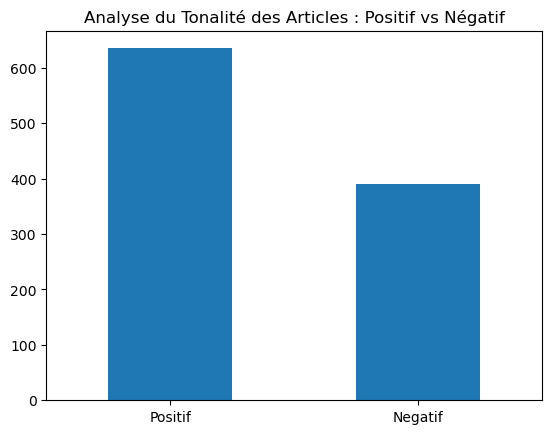

In [53]:
data["sentiment"].map({1:"Positif",0:"Negatif"}).value_counts().plot.bar(rot=0)
plt.title("Analyse du Tonalité des Articles : Positif vs Négatif")
plt.show()

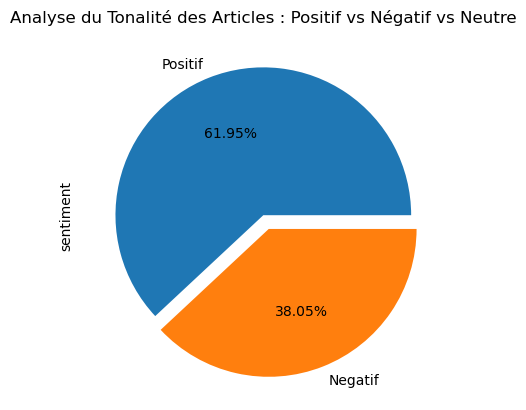

In [54]:
data["sentiment"].map({1:"Positif",0:"Negatif"}).value_counts().plot.pie(autopct="%.2f%%",explode=(0,0.1))
plt.title("Analyse du Tonalité des Articles : Positif vs Négatif vs Neutre")
plt.show()

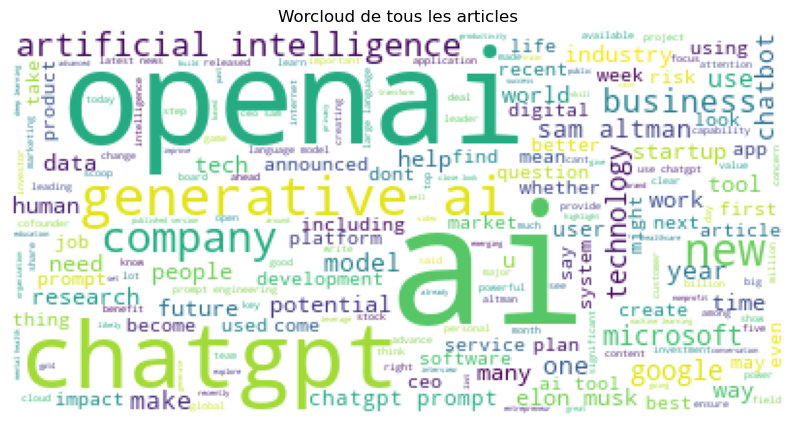

In [47]:
# Worclouds
texte = " ".join(data["content_nettoye"])
plt.figure(figsize=(10,10))
generate_worcloud(texte,"Worcloud de tous les articles")

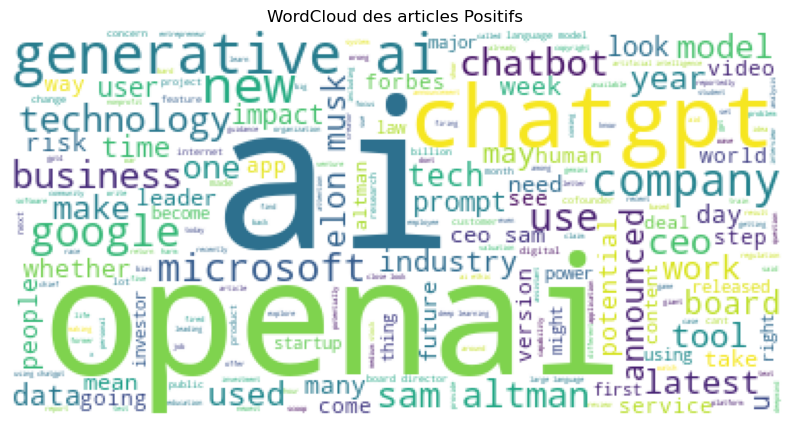

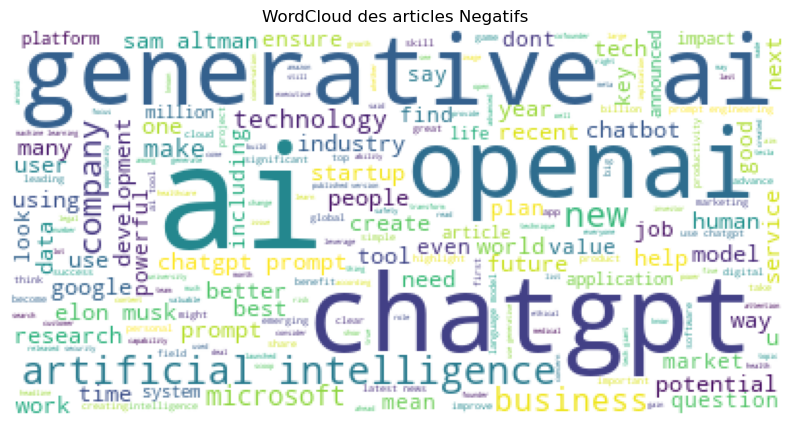

In [55]:
# WordCloud par type d'articles
sentiments = list(data.sentiment.map({1:"Positif",0:"Negatif"}).unique())
for i,sentiment in enumerate(sentiments) :
    plt.subplots(figsize=(10,10))
    text = ' '.join(data.loc[data["sentiment"]==i,"content_nettoye"])
    generate_worcloud(text,f"WordCloud des articles {sentiment}s ")